<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## RNN one-to-many

#### Datos
El objecto es utilizar una serie de sucuencias númericas (datos sintéticos) para poner a prueba el uso de las redes RNN. Este ejemplo se inspiró en otro artículo, lo tienen como referencia en el siguiente link:\
[LINK](https://stackabuse.com/solving-sequence-problems-with-lstm-in-keras/)

In [1]:
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

In [2]:
# torchsummar actualmente tiene un problema con las LSTM, por eso
# se utiliza torchinfo, un fork del proyecto original con el bug solucionado
!pip3 install torchinfo
from torchinfo import summary

In [3]:
import os
import platform

if os.access('torch_helpers.py', os.F_OK) is False:
    if platform.system() == 'Windows':
        !curl !wget https://raw.githubusercontent.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/main/scripts/torch_helpers.py > torch_helpers.py
    else:
        !wget torch_helpers.py https://raw.githubusercontent.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/main/scripts/torch_helpers.py

In [16]:
def train(model, train_loader, valid_loader, optimizer, criterion, epochs=100):
    # Defino listas para realizar graficas de los resultados
    train_loss = []
    valid_loss = []

    # Defino mi loop de entrenamiento

    for epoch in range(epochs):

        epoch_train_loss = 0.0
        epoch_train_accuracy = 0.0

        for train_data, train_target in train_loader:

            # Seteo los gradientes en cero ya que, por defecto, PyTorch
            # los va acumulando
            optimizer.zero_grad()

            output = model(train_data)

            # Computo el error de la salida comparando contra las etiquetas
            loss = criterion(output, train_target)

            # Almaceno el error del batch para luego tener el error promedio de la epoca
            epoch_train_loss += loss.item()

            # Computo el nuevo set de gradientes a lo largo de toda la red
            loss.backward()

            # Realizo el paso de optimizacion actualizando los parametros de toda la red
            optimizer.step()

        # Calculo la media de error para la epoca de entrenamiento.
        # La longitud de train_loader es igual a la cantidad de batches dentro de una epoca.
        epoch_train_loss = epoch_train_loss / len(train_loader)
        train_loss.append(epoch_train_loss)

        # Realizo el paso de validación computando error y accuracy, y
        # almacenando los valores para imprimirlos y graficarlos
        valid_data, valid_target = next(iter(valid_loader))
        output = model(valid_data)
        
        epoch_valid_loss = criterion(output, valid_target).item()
        valid_loss.append(epoch_valid_loss)

        print(f"Epoch: {epoch+1}/{epochs} - Train loss {epoch_train_loss:.3f} - Valid Loss {epoch_valid_loss:.3f}")

    history = {
        "loss": train_loss,
        "val_loss": valid_loss,
    }
    return history

In [17]:
# Generar datos sintéticos
X = list()
y = list()

# X es una lista de números de 1 al 43 que avanzan de 3 en 3
X = [x for x in range(1, 44, 3)]

# "y" (target) se obtiene como por cada dato de entrada se
# se obtienen dos datos de salida como x+1 y x+2
y = [ [x+1, x+2] for x in X]

print("datos X:", X)
print("datos y:", y)

datos X: [1, 4, 7, 10, 13, 16, 19, 22, 25, 28, 31, 34, 37, 40, 43]
datos y: [[2, 3], [5, 6], [8, 9], [11, 12], [14, 15], [17, 18], [20, 21], [23, 24], [26, 27], [29, 30], [32, 33], [35, 36], [38, 39], [41, 42], [44, 45]]


In [18]:
# Cada dato X lo transformarmos en una matriz de 1 fila 1 columna (1x1)
X = np.array(X).reshape(len(X), 1, 1)
print("datos X:", X)

datos X: [[[ 1]]

 [[ 4]]

 [[ 7]]

 [[10]]

 [[13]]

 [[16]]

 [[19]]

 [[22]]

 [[25]]

 [[28]]

 [[31]]

 [[34]]

 [[37]]

 [[40]]

 [[43]]]


In [19]:
# (batch size, seq_len, input_size)
X.shape

(15, 1, 1)

In [20]:
y = np.asanyarray(y)
y.shape

(15, 2)

In [21]:
class Data(Dataset):
    def __init__(self, x, y):
        # Convertir los arrays de numpy a tensores. 
        # pytorch espera en general entradas 32bits
        self.x = torch.from_numpy(x.astype(np.float32))
        # las loss unfction esperan la salida float
        self.y = torch.from_numpy(y.astype(np.float32))

        self.len = self.y.shape[0]

    def __getitem__(self,index):
        return self.x[index], self.y[index]

    def __len__(self):
        return self.len

data_set = Data(X, y)

input_dim = data_set.x.shape[1:]
seq_length = input_dim[0]
input_size = input_dim[1]
print("Input dim", input_dim)
print("seq_length:", seq_length)
print("input_size:", input_size)

output_dim = data_set.y.shape[1]
print("Output dim", output_dim)

Input dim torch.Size([1, 1])
seq_length: 1
input_size: 1
Output dim 2


In [22]:
data_set.x.shape

torch.Size([15, 1, 1])

In [23]:
data_set.y.shape

torch.Size([15, 2])

In [24]:
torch.manual_seed(42)
valid_set_size = int(data_set.len * 0.2)
train_set_size = data_set.len - valid_set_size

# Cuando trabajmos con una serie temporal no mezclamos (shuffle) los datos
train_set = torch.utils.data.Subset(data_set, range(train_set_size))
valid_set = torch.utils.data.Subset(data_set, range(train_set_size, data_set.len))

print("Tamaño del conjunto de entrenamiento:", len(train_set))
print("Tamaño del conjunto de validacion:", len(valid_set))

train_loader = torch.utils.data.DataLoader(train_set, batch_size=len(train_set), shuffle=False)
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=len(valid_set), shuffle=False)

Tamaño del conjunto de entrenamiento: 12
Tamaño del conjunto de validacion: 3


### 2 - Entrenar el modelo

In [25]:
from torch_helpers import CustomLSTM

class Model1(nn.Module):
    def __init__(self, input_size, output_dim):
        super().__init__()

        #self.rnn1 = nn.RNN(input_size=input_size, hidden_size=64, batch_first=True) # RNN layer
        # Utilizamos la CustomRNN ya que para series temporales suele funcionar mejor
        # la activacion "relu" en las RNN en vez de la "tanh", pero por defecto la
        # layer de Pytorch RNN no permite modificar la funcion de activacion
        #self.rnn1 = CustomRNN(input_size=input_size, hidden_size=64) # RNN layer
        self.rnn1 = CustomLSTM(input_size=input_size, hidden_size=64, activation=nn.ReLU()) # RNN layer
        self.fc = nn.Linear(in_features=64, out_features=output_dim) #  # Fully connected layer
        
    def forward(self, x):
        lstm_output, _ = self.rnn1(x)
        out = self.fc(lstm_output[:,-1,:]) # take last output (last seq)
        return out

model1 = Model1(input_size=input_size, output_dim=output_dim)

# Crear el optimizador la una función de error
model1_optimizer = torch.optim.Adam(model1.parameters(), lr=0.01)
model1_criterion = nn.MSELoss()  # mean squared error

summary(model1, input_size=(1, seq_length, input_size))

Layer (type:depth-idx)                   Output Shape              Param #
Model1                                   [1, 2]                    --
├─CustomLSTM: 1-1                        [1, 1, 64]                16,896
│    └─Sigmoid: 2-1                      [1, 64]                   --
│    └─Sigmoid: 2-2                      [1, 64]                   --
│    └─ReLU: 2-3                         [1, 64]                   --
│    └─Sigmoid: 2-4                      [1, 64]                   --
│    └─ReLU: 2-5                         [1, 64]                   --
├─Linear: 1-2                            [1, 2]                    130
Total params: 17,026
Trainable params: 17,026
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00

In [26]:
history1 = train(model1,
                train_loader,
                valid_loader,
                model1_optimizer,
                model1_criterion,
                epochs=500
                )

Epoch: 1/500 - Train loss 461.394 - Valid Loss 1645.036
Epoch: 2/500 - Train loss 448.813 - Valid Loss 1586.869
Epoch: 3/500 - Train loss 434.275 - Valid Loss 1518.657
Epoch: 4/500 - Train loss 417.327 - Valid Loss 1436.544
Epoch: 5/500 - Train loss 397.004 - Valid Loss 1339.484
Epoch: 6/500 - Train loss 372.932 - Valid Loss 1227.604
Epoch: 7/500 - Train loss 344.975 - Valid Loss 1102.000
Epoch: 8/500 - Train loss 313.325 - Valid Loss 965.096
Epoch: 9/500 - Train loss 278.395 - Valid Loss 819.937
Epoch: 10/500 - Train loss 240.831 - Valid Loss 670.320
Epoch: 11/500 - Train loss 201.510 - Valid Loss 521.028
Epoch: 12/500 - Train loss 161.611 - Valid Loss 377.950
Epoch: 13/500 - Train loss 122.564 - Valid Loss 247.920
Epoch: 14/500 - Train loss 86.049 - Valid Loss 138.395
Epoch: 15/500 - Train loss 53.971 - Valid Loss 56.862
Epoch: 16/500 - Train loss 28.339 - Valid Loss 9.972
Epoch: 17/500 - Train loss 11.060 - Valid Loss 2.093
Epoch: 18/500 - Train loss 3.550 - Valid Loss 32.345
Epoch:

Epoch: 56/500 - Train loss 2.455 - Valid Loss 7.517
Epoch: 57/500 - Train loss 2.055 - Valid Loss 5.291
Epoch: 58/500 - Train loss 1.686 - Valid Loss 3.350
Epoch: 59/500 - Train loss 1.400 - Valid Loss 1.854
Epoch: 60/500 - Train loss 1.225 - Valid Loss 0.851
Epoch: 61/500 - Train loss 1.163 - Valid Loss 0.299
Epoch: 62/500 - Train loss 1.193 - Valid Loss 0.093
Epoch: 63/500 - Train loss 1.282 - Valid Loss 0.104
Epoch: 64/500 - Train loss 1.393 - Valid Loss 0.207
Epoch: 65/500 - Train loss 1.490 - Valid Loss 0.305
Epoch: 66/500 - Train loss 1.549 - Valid Loss 0.345
Epoch: 67/500 - Train loss 1.558 - Valid Loss 0.313
Epoch: 68/500 - Train loss 1.516 - Valid Loss 0.232
Epoch: 69/500 - Train loss 1.434 - Valid Loss 0.147
Epoch: 70/500 - Train loss 1.330 - Valid Loss 0.109
Epoch: 71/500 - Train loss 1.221 - Valid Loss 0.160
Epoch: 72/500 - Train loss 1.127 - Valid Loss 0.322
Epoch: 73/500 - Train loss 1.058 - Valid Loss 0.592
Epoch: 74/500 - Train loss 1.020 - Valid Loss 0.941
Epoch: 75/50

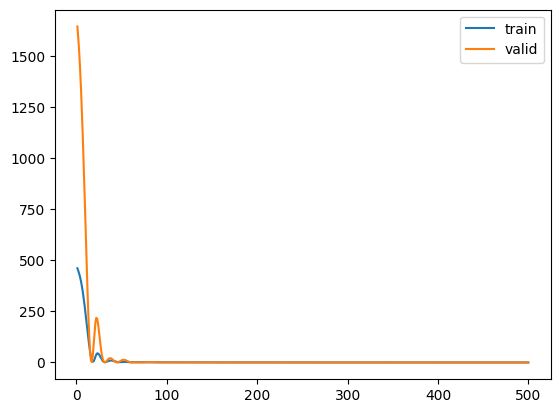

In [27]:
epoch_count = range(1, len(history1['loss']) + 1)
sns.lineplot(x=epoch_count,  y=history1['loss'], label='train')
sns.lineplot(x=epoch_count,  y=history1['val_loss'], label='valid')
plt.show()

In [28]:
# Ensayo
x_test = 10
y_test = [x_test + 1, x_test + 2]
test_input = np.array([x_test])
test_input = test_input.reshape((1, seq_length, input_size))
test_input = torch.from_numpy(test_input.astype(np.float32))

test_target = torch.from_numpy(np.array(y_test).astype(np.int32)).float().view(-1, 1)

y_hat = model1(test_input)

print("y_test:", y_test)
print("y_hat:", y_hat)

loss = model1_criterion(y_hat, test_target).item()
print("loss:", loss)

y_test: [11, 12]
y_hat: tensor([[11.1716, 12.0539]], grad_fn=<AddmmBackward0>)
loss: 0.4573024809360504


d:\Users\juanp_schamun\Documents\GitRepositories\CEIA\procesamiento_lenguaje_natural\.venv\Lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([2, 1])) that is different to the input size (torch.Size([1, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


### 3 - Multi-layer LSTM

In [29]:
from torch_helpers import CustomLSTM

# En esta oportunidad se utilizarán dos layer LSTM
class Model2(nn.Module):
    def __init__(self, input_size, output_dim):
        super().__init__()

        self.lstm1 = CustomLSTM(input_size=input_size, hidden_size=64, activation=nn.ReLU()) # LSTM layer
        self.lstm2 = CustomLSTM(input_size=64, hidden_size=64, activation=nn.ReLU()) # LSTM layer
        self.fc = nn.Linear(in_features=64, out_features=output_dim) #  # Fully connected layer
        
    def forward(self, x):
        lstm_output, _ = self.lstm1(x)
        lstm_output, _ = self.lstm2(lstm_output)
        out = self.fc(lstm_output[:,-1,:]) # take last output (last seq)
        return out

model2 = Model2(input_size=input_size, output_dim=output_dim)

# Crear el optimizador la una función de error
model2_optimizer = torch.optim.Adam(model2.parameters(), lr=0.01)
model2_criterion = nn.MSELoss()  # mean squared error

summary(model2, input_size=(1, seq_length, input_size))

Layer (type:depth-idx)                   Output Shape              Param #
Model2                                   [1, 2]                    --
├─CustomLSTM: 1-1                        [1, 1, 64]                16,896
├─CustomLSTM: 1-4                        --                        (recursive)
│    └─Sigmoid: 2-1                      [1, 64]                   --
│    └─Sigmoid: 2-2                      [1, 64]                   --
├─CustomLSTM: 1-5                        --                        (recursive)
│    └─ReLU: 2-3                         [1, 64]                   --
├─CustomLSTM: 1-4                        --                        (recursive)
│    └─Sigmoid: 2-4                      [1, 64]                   --
├─CustomLSTM: 1-5                        --                        (recursive)
│    └─ReLU: 2-5                         [1, 64]                   --
├─CustomLSTM: 1-6                        [1, 1, 64]                33,024
│    └─Sigmoid: 2-6                      

In [30]:
history2 = train(model2,
                train_loader,
                valid_loader,
                model2_optimizer,
                model2_criterion,
                epochs=500
                )

Epoch: 1/500 - Train loss 467.598 - Valid Loss 1709.727
Epoch: 2/500 - Train loss 463.414 - Valid Loss 1687.175
Epoch: 3/500 - Train loss 458.040 - Valid Loss 1650.086
Epoch: 4/500 - Train loss 449.783 - Valid Loss 1583.337
Epoch: 5/500 - Train loss 435.823 - Valid Loss 1469.646
Epoch: 6/500 - Train loss 412.395 - Valid Loss 1295.293
Epoch: 7/500 - Train loss 375.383 - Valid Loss 1058.281
Epoch: 8/500 - Train loss 321.707 - Valid Loss 775.773
Epoch: 9/500 - Train loss 251.206 - Valid Loss 476.871
Epoch: 10/500 - Train loss 169.264 - Valid Loss 201.293
Epoch: 11/500 - Train loss 87.447 - Valid Loss 19.359
Epoch: 12/500 - Train loss 24.891 - Valid Loss 60.612
Epoch: 13/500 - Train loss 11.843 - Valid Loss 368.619
Epoch: 14/500 - Train loss 62.978 - Valid Loss 535.252
Epoch: 15/500 - Train loss 97.301 - Valid Loss 446.657
Epoch: 16/500 - Train loss 82.606 - Valid Loss 259.280
Epoch: 17/500 - Train loss 47.589 - Valid Loss 100.376
Epoch: 18/500 - Train loss 18.429 - Valid Loss 17.294
Epoch

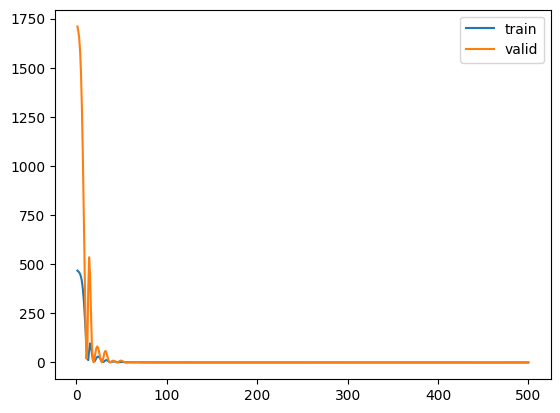

In [31]:
epoch_count = range(1, len(history2['loss']) + 1)
sns.lineplot(x=epoch_count,  y=history2['loss'], label='train')
sns.lineplot(x=epoch_count,  y=history2['val_loss'], label='valid')
plt.show()

In [32]:
# Ensayo
x_test = 10
y_test = [x_test + 1, x_test + 2]
test_input = np.array([x_test])
test_input = test_input.reshape((1, seq_length, input_size))
test_input = torch.from_numpy(test_input.astype(np.float32))

test_target = torch.from_numpy(np.array(y_test).astype(np.int32)).float().view(-1, 1)

y_hat = model2(test_input)

print("y_test:", y_test)
print("y_hat:", y_hat)

loss = model2_criterion(y_hat, test_target).item()
print("loss:", loss)

y_test: [11, 12]
y_hat: tensor([[11.0494, 12.0359]], grad_fn=<AddmmBackward0>)
loss: 0.4951225519180298


d:\Users\juanp_schamun\Documents\GitRepositories\CEIA\procesamiento_lenguaje_natural\.venv\Lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([2, 1])) that is different to the input size (torch.Size([1, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


### 4 - Conclusión
La unica diferencia que se debe tener en cuenta cuando hay más de una salida es que la cantidad de neuronas de la última capa debe coincidir con el tamaño de la secuencia de salida.
En este ejemplo, donde el problema es más complejo, hubo una diferencia apreciable entre utilizar una sola capa o varias LSTM.